## In this notebook, we try to get the thermodynamic factors of the LiPF6 in EC:EMC system based on the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.


In [106]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; 
from openpyxl import load_workbook
import sympy as sy; from sympy import symbols,diff
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os

In [107]:
###### NOTE: m here refer to the molality of salt   ##############
def Act_Sol_Bin_i_m_np(m,m_bar_i,para_i_salt): 
    """ Eq. (2) in Self 2024 paper, 
    For solvent only, in binary electrolyte system """
    # Unpack parameter:
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    first_term = 1 - 2*m  /  ( 1/m_bar_i + 2*m )
    power = (
        c_i_salt*m**1.5 + d_i_salt*m**2.0 + 
        e_i_salt*m**2.5 + f_i_salt*m**3.0 )
    a_i_m = first_term * np.exp(power)    # use np
    return a_i_m
def Act_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt): 
    """ Eq. (2) in Self 2024 paper, 
    For solvent only, in binary electrolyte system """
    # Unpack parameter:
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    first_term = 1 - 2*m  /  ( 1/m_bar_i + 2*m )
    power = (
        c_i_salt*m**1.5 + d_i_salt*m**2.0 + 
        e_i_salt*m**2.5 + f_i_salt*m**3.0 )
    a_i_m = first_term * sy.exp(power)    # use sy
    return a_i_m

def Act_Sol_Bin_i_Xj_np(X_j_apo,para_i_j): 
    """ Eq. (3) in Self 2024 paper, 
    For solvent only, in binary solvent system """
    # Unpack parameter:
    [c_i_j,d_i_j,e_i_j] = para_i_j
    first_term = 1 - X_j_apo   # Mark: equation said X_j but script said X_j_apo # confusing but actually correct
    power = (
        c_i_j*X_j_apo**2.0 +   # Mark: equation said X_j but script said X_j_apo # confusing but actually correct
        d_i_j*X_j_apo**3.0 + 
        e_i_j*X_j_apo**4.0  )
    a_i_Xj = first_term * np.exp(power)
    return a_i_Xj
def Act_Sol_Bin_i_Xj_sy(X_j_apo,para_i_j): 
    """ Eq. (3) in Self 2024 paper, 
    For solvent only, in binary solvent system """
    # Unpack parameter:
    [c_i_j,d_i_j,e_i_j] = para_i_j
    first_term = 1 - X_j_apo   # Mark: equation said X_j but script said X_j_apo # confusing but actually correct
    power = (
        c_i_j*X_j_apo**2.0 +   # Mark: equation said X_j but script said X_j_apo # confusing but actually correct
        d_i_j*X_j_apo**3.0 + 
        e_i_j*X_j_apo**4.0  )
    a_i_Xj = first_term * sy.exp(power)
    return a_i_Xj

def Act_Sol_Ter_i_np(X_i,X_j,m,m_bar_i,Para): 
    """ Eq. (7) in Self 2024 paper, 
    For solvent only, in ternary system (2 solvent 1 salt) """
    # Unpack parameter:
    para_i_salt,para_i_j,para_i_j_salt = Para
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt

    X_j_apo =  X_j / (X_i+X_j)  # apo short for apostrophe
    X_i_apo =  X_i / (X_i+X_j)  

    first_term = X_i         # Mark Eq. (7) said X_i but script said X_i_apo
    second_term= Act_Sol_Bin_i_Xj_np(X_j_apo,para_i_j) / (1-X_j_apo)  # confusing but actually correct
    third_term = Act_Sol_Bin_i_m_np(m,m_bar_i,para_i_salt)  / (1 - 2*m  /  ( 1/m_bar_i + 2*m ))      
    power = (
        c_i_j_salt*m**1.5*X_j_apo**2.0 + 
        d_i_j_salt*m**1.5*X_j_apo**3.0 + 
        e_i_j_salt*m**2.0*X_j_apo**2.0  )
    a_i_Xj_m = first_term*second_term*third_term * np.exp(power)
    return a_i_Xj_m

def Act_Sol_Ter_i_sy(X_i,X_j,m,m_bar_i,Para): 
    """ Eq. (7) in Self 2024 paper, 
    For solvent only, in ternary system (2 solvent 1 salt) """
    # Unpack parameter:
    para_i_salt,para_i_j,para_i_j_salt = Para
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt

    X_j_apo =  X_j / (X_i+X_j)  # apo short for apostrophe
    X_i_apo =  X_i / (X_i+X_j)  

    first_term = X_i         # Mark Eq. (7) said X_i but script said X_i_apo
    second_term= Act_Sol_Bin_i_Xj_sy(X_j_apo,para_i_j) / (1-X_j_apo)  # confusing but actually correct
    third_term = Act_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt)  / (1 - 2*m  /  ( 1/m_bar_i + 2*m ))      
    power = (
        c_i_j_salt*m**1.5*X_j_apo**2.0 + 
        d_i_j_salt*m**1.5*X_j_apo**3.0 + 
        e_i_j_salt*m**2.0*X_j_apo**2.0  )
    a_i_Xj_m = first_term*second_term*third_term * sy.exp(power)
    return a_i_Xj_m
def Act_Sol_Ter_EMC_sy(X_i,X_j,m,m_bar_i,Para): 
    """ Eq. (7) in Self 2024 paper, 
    For solvent only, in ternary system (2 solvent 1 salt) """
    # Unpack parameter:
    para_i_salt,para_i_j,para_i_j_salt = Para
    X_j_apo =  X_j / (X_i+X_j)  # apo short for apostrophe
    X_i_apo =  X_i / (X_i+X_j)  

    first_term = X_i         # Mark Eq. (7) said X_i but script said X_i_apo
    second_term= Act_Sol_Bin_i_Xj_sy(X_j_apo,para_i_j) / (1-X_j_apo)  # confusing but actually correct
    third_term = Act_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt)  / (1 - 2*m  /  ( 1/m_bar_i + 2*m ))      
    
    a_i_Xj_m = first_term*second_term*third_term
    return a_i_Xj_m

#### To test whether we type the equations correctly, we try to implement Eq. (10) in Self 2024 paper, and compare the results with Fig. 3 

In [108]:
m_bar_EC = 88.062*1e-3 #   kg/mol
m_bar_0  = 104.105*1e-3 #   kg/mol
m_bar_EMC= 104.105*1e-3 #   kg/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
# assume 1 kg EC and EMC, 
n_EC  = 0.5 / m_bar_EC   # unit: mol
n_EMC = 0.5 / m_bar_0    # unit: mol
m_EC  = n_EC/ 1          # unit: mol/kg
m_EMC = n_EMC/ 1         # unit: mol/kg
print(f"When mass ratio is 1:1, mole ratio of EC and EMC are: {n_EC/n_EMC:.4f}, roughly equal to 1.2")
print(f"Molalities are: m_EC={m_EC:.4f}, m_EMC={m_EMC:.4f} mol/kg")

When mass ratio is 1:1, mole ratio of EC and EMC are: 1.1822, roughly equal to 1.2
Molalities are: m_EC=5.6778, m_EMC=4.8028 mol/kg


In [109]:
# reproduce eq. (10)
def Fun_Intergral_sy(m,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC):
    """ Eq. (10) """
    X_EC  = m_EC  / (m_EC+m_EMC+2*m)
    X_EMC = m_EMC / (m_EC+m_EMC+2*m)

    # i=EMC, j=EC
    a_EMC_XEC_m = Act_Sol_Ter_EMC_sy(X_EMC,X_EC,m,m_bar_EMC,Para_EMC)
    # [para_EMC_salt,para_EMC_EC,para_EMC_EC_salt] = Para_EC
    # a_EMC_XEMC   = Act_Sol_Bin_i_Xj_sy(X_EMC,para_EMC_EC)
    a_EMC_XEC_0   = Act_Sol_Ter_EMC_sy(X_EMC,X_EC,0,m_bar_EMC,Para_EMC)
    first_term = m_EMC * np.log(a_EMC_XEC_m / a_EMC_XEC_0)

    # i=EC, j=EMC
    a_EC_XEMC_m = Act_Sol_Ter_i_sy(X_EC,X_EMC,m,m_bar_EC,Para_EC)
    # [para_EC_salt,para_EC_EMC,para_EC_EMC_salt] = Para_EC
    # a_EC_XEMC   = Act_Sol_Bin_i_Xj_sy(X_EMC,para_EC_EMC)
    a_EC_XEMC_0 = Act_Sol_Ter_i_sy(X_EC,X_EMC,0,m_bar_EC,Para_EC)
    second_term  = m_EC * sy.log(a_EC_XEMC_m / a_EC_XEMC_0)

    Intergral = -0.5* (first_term + second_term)
    return Intergral
def Fun_Intergral_np(m,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC):
    """ Eq. (10) """
    X_EC  = m_EC  / (m_EC+m_EMC+2*m)
    X_EMC = m_EMC / (m_EC+m_EMC+2*m)

    # i=EMC, j=EC
    a_EMC_XEC_m = Act_Sol_Ter_i_np(X_EMC,X_EC,m,m_bar_EMC,Para_EMC)
    # [para_EMC_salt,para_EMC_EC,para_EMC_EC_salt] = Para_EC
    # a_EMC_XEMC   = Act_Sol_Bin_i_Xj_np(X_EMC,para_EMC_EC)
    a_EMC_XEC_0   = Act_Sol_Ter_i_np(X_EMC,X_EC,0,m_bar_EMC,Para_EMC)
    first_term = m_EMC * np.log(a_EMC_XEC_m / a_EMC_XEC_0)

    # i=EC, j=EMC
    a_EC_XEMC_m = Act_Sol_Ter_i_np(X_EC,X_EMC,m,m_bar_EC,Para_EC)
    # [para_EC_salt,para_EC_EMC,para_EC_EMC_salt] = Para_EC
    # a_EC_XEMC   = Act_Sol_Bin_i_Xj_np(X_EMC,para_EC_EMC)
    a_EC_XEMC_0 = Act_Sol_Ter_i_np(X_EC,X_EMC,0,m_bar_EC,Para_EC)
    second_term  = m_EC * np.log(a_EC_XEMC_m / a_EC_XEMC_0)

    Intergral = -0.5* (first_term + second_term)
    return Intergral
def Fun_act_sy(m,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC):
    """ Eq. (10) """
    X_EC  = m_EC  / (m_EC+m_EMC+2*m)
    X_EMC = m_EMC / (m_EC+m_EMC+2*m)

    a_EMC_XEC_m = Act_Sol_Ter_EMC_sy(X_EMC,X_EC,m,m_bar_EMC,Para_EMC)
    
    a_EC_XEMC_m = Act_Sol_Ter_i_sy(X_EC,X_EMC,m,m_bar_EC,Para_EC)
  
    return a_EMC_XEC_m,a_EC_XEMC_m

# instead of using Eq. (10), directly use Eq. (8)
def Fun_TDF_sy(m,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC):
    """ Eq. (8) """
    x=symbols("x",real=True)
    X_EC  = m_EC  / (m_EC+m_EMC+2*m)
    X_EMC = m_EMC / (m_EC+m_EMC+2*m)

    # i=EC, j=EMC
    a_EC_XEMC_m = Act_Sol_Ter_i_sy(X_EC,X_EMC,m,m_bar_EC,Para_EC)
    first_term   = 0.5/m**2 * m_EC * diff(sy.log(a_EC_XEMC_m),m)
    # i=EMC, j=EC
    a_EMC_XEC_m = Act_Sol_Ter_i_sy(X_EMC,X_EC,x,m_bar_EMC,Para_EMC)
    second_term = 0.5/m**2 * m_EMC * diff(sy.log(a_EMC_XEC_m),m)

    TDF = first_term + second_term
    return TDF


In [110]:
# Define input - from Table 2 and 3 in Self 2024 paper
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671]
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636]
Para_EC  = [para_EC_salt,para_EC_EMC,para_EC_EMC_salt]

para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]
para_EMC_EC   = [0.62190, 2.5617,  -2.5672         ]
para_EMC_EC_salt = [0,0,0]    # Table 3 miss values but actually should be zero
Para_EMC = [para_EMC_salt,para_EMC_EC,para_EMC_EC_salt]


# Int       = Fun_Intergral_sy(x,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC)
Int_test = []
m_e_List =  np.linspace(0.0,1.31,100).tolist()
for m_e in m_e_List:
    # Int_test.append(Int.subs({x:m_e}))
    Int_test.append(Fun_Intergral_np(m_e,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC))


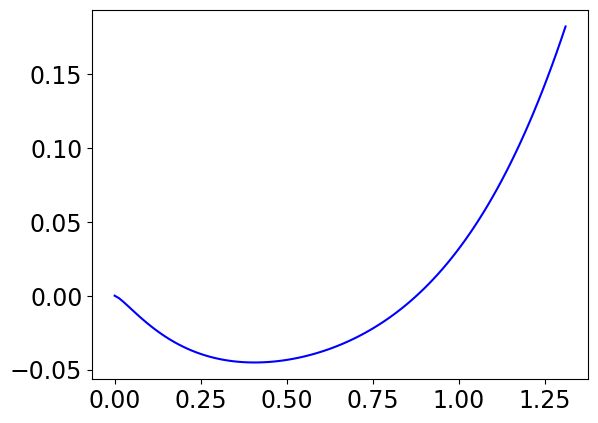

In [111]:
plt.plot(m_e_List, Int_test,'b',label="EC:EMC 6:5")

In [112]:
a_EMC_XEC_m=[];    a_EC_XEMC_m = []
for m_e in m_e_List:
    a_EMC_XEC_m_i,a_EC_XEMC_m_i=Fun_act_sy(
        m_e,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC)
    a_EMC_XEC_m.append(a_EMC_XEC_m_i)
    a_EC_XEMC_m.append(a_EC_XEMC_m_i)

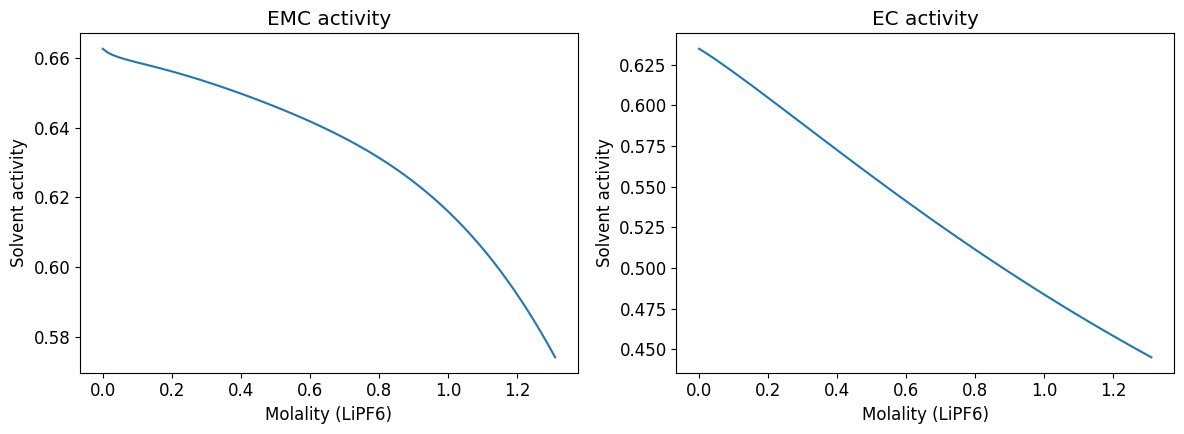

In [113]:
# plot activity
# Plot:
plt.rc('font', size=12)
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
axs[0].plot(m_e_List,a_EMC_XEC_m)
axs[1].plot(m_e_List,a_EC_XEMC_m)
axs[0].set_title("EMC activity")
axs[1].set_title("EC activity")
for i in range(2):
    axs[i].set_ylabel("Solvent activity")
    axs[i].set_xlabel("Molality (LiPF6)")

In [114]:
x=symbols("x",real=True)
TDF_Salt =  diff(Fun_Intergral_sy(x,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC),x)
TDF_Salt2 = Fun_TDF_sy(x,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC)
TDF_Salt_List = []
TDF_Salt_List2 = []
for m_e in m_e_List:
    TDF_Salt_List.append(TDF_Salt.subs({x:m_e}))
    TDF_Salt_List2.append(TDF_Salt2.subs({x:m_e}))


TypeError: loop of ufunc does not support argument 0 of type Mul which has no callable log method

/home/ruihe_li/EnvPBGEM_ECDrag2/lib/python3.10/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


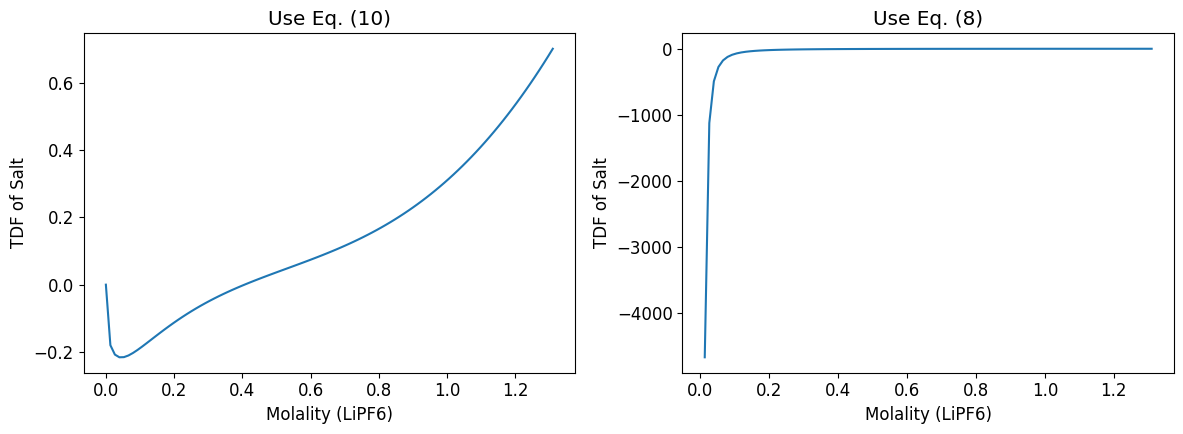

In [ ]:
# Plot:
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
axs[0].plot(m_e_List,TDF_Salt_List)
axs[1].plot(m_e_List,TDF_Salt_List2)
axs[0].set_title("Use Eq. (10)")
axs[1].set_title("Use Eq. (8)")
for i in range(2):
    axs[i].set_ylabel("TDF of Salt")
    axs[i].set_xlabel("Molality (LiPF6)")

### OK, that fails, may be due to some problems in equations, or somewhere. Now directly look at TDF in Jung 2023 paper notation

In [ ]:
# basic input: c_e, c_EC
# Get: m_e, X_EC, X_EMC
def Fun_rho(c_e, c_EC):
    rho_0,rho_1,rho_2 = 1006.1, 0.02235185918895445, 0.10065156540490541
    return rho_0  + rho_1 * c_EC + rho_2 * c_e
def Fun_c_T(c_e, c_EC):
    b = (
        (m_bar_EC-m_bar_0) * c_EC 
        + (m_bar_e-2*m_bar_0)*c_e  ) 
    c_T= (Fun_rho(c_e, c_EC ) - b) / m_bar_0
    return c_T
def Fun_Trans(c_e, c_EC):
    rho  = Fun_rho(c_e, c_EC)
    c_T  = Fun_c_T(c_e, c_EC) 
    m_e  = c_e  / (rho - c_e*m_bar_e)
    X_e  = c_e  / c_T
    X_EC = c_EC / c_T
    X_EMC= 1 - 2*X_e - X_EC
    return m_e,X_EC,X_EMC
def Fun_a_EC(c_e, c_EC):
    m_e,X_EC,X_EMC = Fun_Trans(c_e, c_EC)
    a_EC  = Act_Sol_Ter_i_np(X_EC,X_EMC,m_e,m_bar_EC,Para_EC)
    return a_EC
def Fun_a_EMC(c_e, c_EC):
    m_e,X_EC,X_EMC = Fun_Trans(c_e, c_EC)
    a_EMC = Act_Sol_Ter_i_np(X_EMC,X_EC,m_e,m_bar_EMC,Para_EMC)
    return a_EMC


In [ ]:
rho_0,rho_1,rho_2 = 1006.1, 0.02235185918895445, 0.10065156540490541
V_bar_0  = m_bar_0 / rho_0
V_bar_EC = (m_bar_EC - rho_1) / rho_0
V_bar_e = (m_bar_e - rho_2) / rho_0

def Fun_c_T_y(y_e, y_EC):
    denominator = V_bar_0 + (V_bar_EC-V_bar_0)*y_EC + (V_bar_e-2*V_bar_0)*y_e
    return 1 / denominator
def Fun_Trans_y2m(y_e, y_EC):
    c_T  = Fun_c_T_y(y_e, y_EC) 
    c_e  = y_e * c_T
    c_EC = y_EC* c_T
    rho  = Fun_rho(c_e, c_EC)
    m_e  = c_e  / (rho - c_e*m_bar_e)
    return m_e
def Fun_a_EC_y(y_e, y_EC):
    m_e = Fun_Trans_y2m(y_e, y_EC)
    y_EMC= 1 - 2*y_e - y_EC
    a_EC  = Act_Sol_Ter_i_sy(y_EC,y_EMC,m_e,m_bar_EC,Para_EC)
    return a_EC
def Fun_a_EMC_y(y_e, y_EC):
    m_e = Fun_Trans_y2m(y_e, y_EC)
    y_EMC= 1 - 2*y_e - y_EC
    a_EMC = Act_Sol_Ter_i_sy(y_EMC,y_EC,m_e,m_bar_EMC,Para_EMC)
    return a_EMC


def Fun_X_ee_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    a_EMC= Fun_a_EMC_y(y_e, y_EC)
    y_EMC= 1 - 2*y_e - y_EC

    first_term = -y_EC * diff(sy.log(a_EC),y_e)
    second_term= -y_EMC* diff(sy.log(a_EMC),y_e)

    return first_term + second_term - 2
def Fun_X_eo_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    a_EMC= Fun_a_EMC_y(y_e, y_EC)
    y_EMC= 1 - 2*y_e - y_EC
    first_term = -y_EC * diff(sy.log(a_EC),y_EC)
    second_term= -y_EMC* diff(sy.log(a_EMC),y_EC)
    return first_term + second_term
def Fun_X_oe_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    return y_EC * diff(sy.log(a_EC),y_e)

def Fun_X_oo_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    return y_EC * diff(sy.log(a_EC),y_EC) - 1


/tmp/ipykernel_11859/168124026.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(y_EC_list))


Text(0.5, 0, '$y_\\mathrm{e}$')

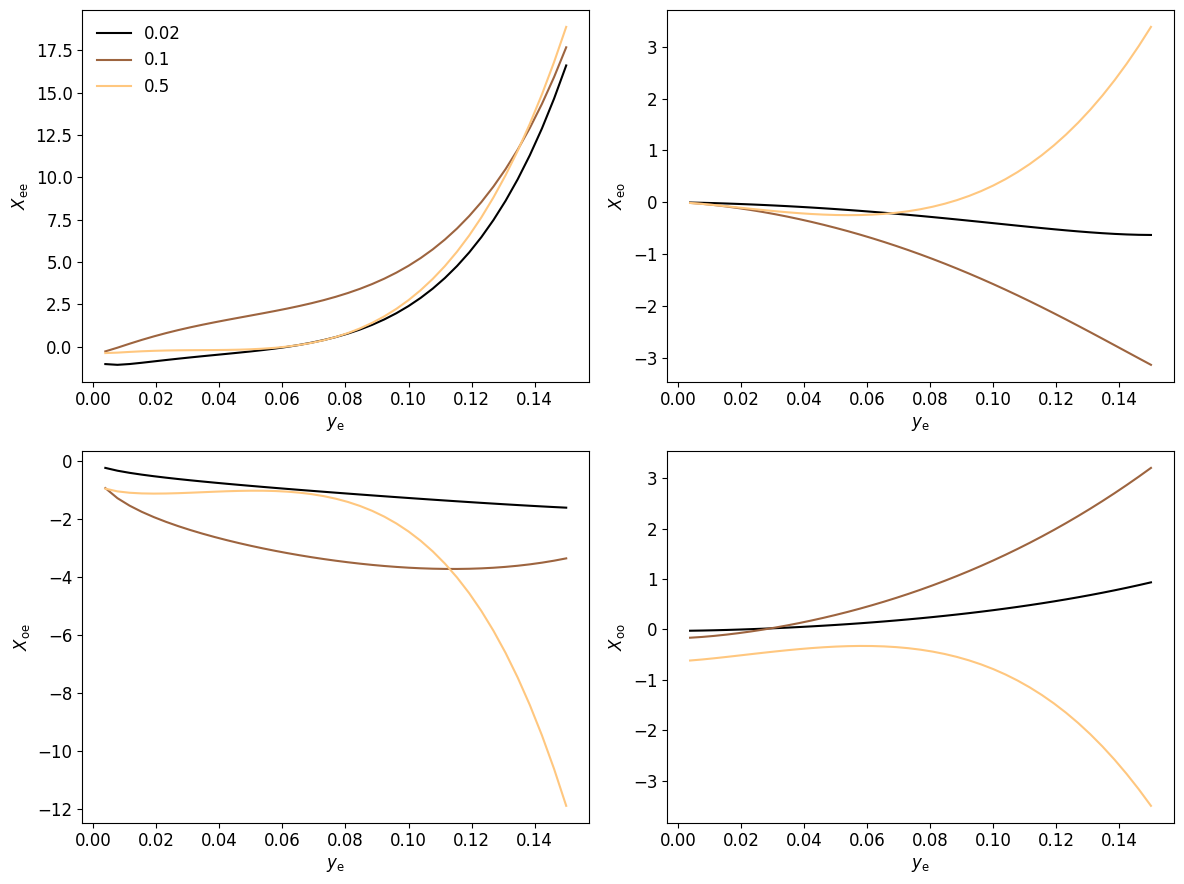

In [ ]:
y_e, y_EC = symbols("y_e y_EC",real=True)
y_EC_list = [0.02, 0.1, 0.5]
cop2 = mpl.cm.get_cmap("copper", len(y_EC_list))
y_e_array = np.linspace(0.000,0.15,40)
fig, Axs = plt.subplots(2,2, figsize=(12,9),tight_layout=True)
axs = Axs.flatten()
for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_ee_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[0].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[0].set_ylabel("$X_\mathrm{ee}$")
axs[0].set_xlabel("$y_\mathrm{e}$")
axs[0].legend(frameon=False)

for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_eo_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[1].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[1].set_ylabel("$X_\mathrm{eo}$")
axs[1].set_xlabel("$y_\mathrm{e}$")

for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_oe_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[2].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[2].set_ylabel("$X_\mathrm{oe}$")
axs[2].set_xlabel("$y_\mathrm{e}$")

for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_oo_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[3].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[3].set_ylabel("$X_\mathrm{oo}$")
axs[3].set_xlabel("$y_\mathrm{e}$")